In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [39]:

# Load the class labels
labels_path = 'coco.names'
labels = open(labels_path).read().strip().split('\n')



In [40]:

# Defining paths to the weights and configuration file with model of Neural Network
weights_path = 'yolov3.weights'
configuration_path = 'yolov3.cfg'


In [41]:
# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.6  # lowered for debugging

# Setting threshold for non-maximum suppression
threshold = 0.7


In [46]:
# Load YOLO network
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

# Get the names of all layers in the network
layer_names_all = network.getLayerNames()
print(str(len(layer_names_all)))

254


In [43]:
# Get the names of the output layers (the layers that YOLO uses to detect objects)
output_layer_names = [layer_names_all[i - 1] for i in network.getUnconnectedOutLayers()]

# Load input image
image_path = 'ph1.png'
image_input = cv2.imread(image_path)


In [45]:

height, width = image_input.shape[:2]

# Create a blob from the input image
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)
network.setInput(blob)

# Perform forward pass and get the outputs
layer_outputs = network.forward(output_layer_names)
print(output_layer_names)
print(str(len(layer_outputs)))

['yolo_82', 'yolo_94', 'yolo_106']
3


In [34]:

# Initialize lists for detected bounding boxes, confidences, and class IDs
boxes = []
confidences = []
class_ids = []

# Iterate over each output layer
for output in layer_outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > probability_minimum:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


In [35]:
# Perform non-maximum suppression to eliminate redundant overlapping boxes with lower confidences
indexes = cv2.dnn.NMSBoxes(boxes, confidences, probability_minimum, threshold)

# Draw the bounding boxes and labels on the image
font = cv2.FONT_HERSHEY_SIMPLEX
colors = np.random.uniform(0, 134, size=(len(labels), 3))

In [36]:
if len(indexes) > 0:
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        color = colors[class_ids[i]]
        label = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
        
        cv2.rectangle(image_input, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image_input, label, (x, y - 10), font, 0.5, color, 2)

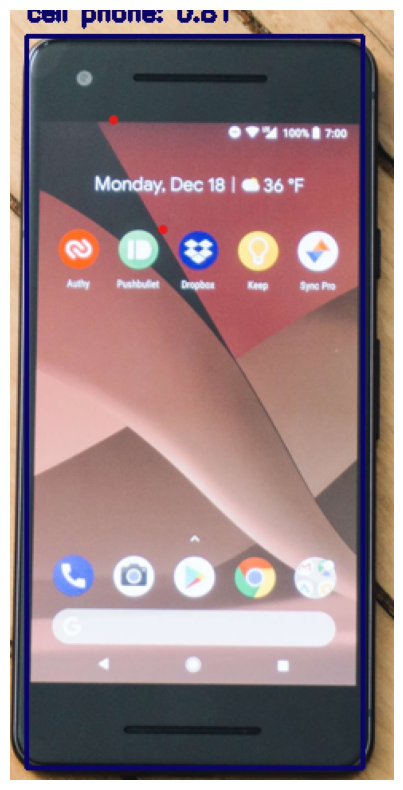

In [37]:
# Convert the image to RGB format for displaying with matplotlib
image_input_rgb = cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB)

# Display the output image
plt.figure(figsize=(10, 10))
plt.imshow(image_input_rgb)
plt.axis('off')
plt.show()